In [1]:
import os
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy
import scipy.linalg

from pr3_utils import *

In [17]:
# define constants
STEREO_BASELINE = 0.6    # (in m)
P_const = np.zeros((3,4))
P_const[:3,:3] = np.eye(3)

# define motion and observation model noise covariance matrix
WvelCov = 1e-4
WangVelCov = 1e-4
Vcov = 1
initLMCov = 2*1e-1
initPoseCov = 1e-4

W = np.diag([1,1,1,1,1,1])     # (6,6)
W[[0,1,2],[0,1,2]] = W[[0,1,2],[0,1,2]] * WvelCov
W[[3,4,5],[3,4,5]] = W[[3,4,5],[3,4,5]] * WangVelCov
V = np.diag([1,1,1,1]) * Vcov         # (4,4)

In [3]:
# Load the measurements
filename = "../data/10.npz"
stamps, featOrig, lin_vel, ang_vel, K, stereoBaseline, imu_T_cam = load_data(filename)   # linear and angular velocity in IMU frame
print(stamps.shape, featOrig.shape, lin_vel.shape, ang_vel.shape, K.shape, stereoBaseline, imu_T_cam.shape)

featSkip = 10
features = featOrig[:,::featSkip,:]

N = stamps.shape[0]
M = features.shape[1]
obsDim = features.shape[2]

Ks = np.zeros((4,4))
Ks[:2,:3] = K[:2,:3]
Ks[2:,:3] = K[:2,:3]
Ks[2,3] = -stereoBaseline * K[0,0]

RF_T_OF = np.zeros((4,4))
RF_T_OF[1,0] = -1
RF_T_OF[2,1] = -1
RF_T_OF[0,2] = 1
RF_T_OF[3,3] = 1

IFhat_T_CF = imu_T_cam
IF_T_IFhat = np.eye(4)
IF_T_IFhat[1,1] = -1
IF_T_IFhat[2,2] = -1
IF_T_CF = np.matmul(IF_T_IFhat, IFhat_T_CF)
CF_T_IF = np.linalg.inv(IF_T_CF)

print("Number of timestamps:", N)
print("Total landmarks:", M)
print("SE(3) transformation Left Cam to IMU\n", IF_T_CF)

(3026, 1) (3026, 13289, 4) (3026, 3) (3026, 3) (3, 3) 0.6 (4, 4)
Number of timestamps: 3026
Total landmarks: 1329
SE(3) transformation Left Cam to IMU
 [[ 0.03717833 -0.09861822  0.9944306   1.5752681 ]
 [-0.99926755  0.00535534  0.03789026 -0.00439141]
 [-0.00906218 -0.99511094 -0.09834688  0.65      ]
 [ 0.          0.          0.          1.        ]]


In [4]:
# camdown0_T_imu = np.array([[0,1,0,-0.02], [0,0,1,0], [1,0,0,-1.6], [0,0,0,1]])
# phi = 5. * np.pi / 180
# camdown5_T_camdown0 = np.array([[1,0,0,0], [0,np.cos(phi),-np.sin(phi),0], [0,np.sin(phi),np.cos(phi),0], [0,0,0,1]])
# cam_T_imu = np.matmul(camdown5_T_camdown0, camdown0_T_imu)
# print(np.linalg.inv(cam_T_imu))

## (a) IMU Localization via EKF Prediction step based on the SE(3) kinematics equations and linear and angular velocity measurements from IMU to estimate IMU pose \in SE(3) over time t

100%|████████████████████████████████████| 3025/3025 [00:00<00:00, 15763.83it/s]


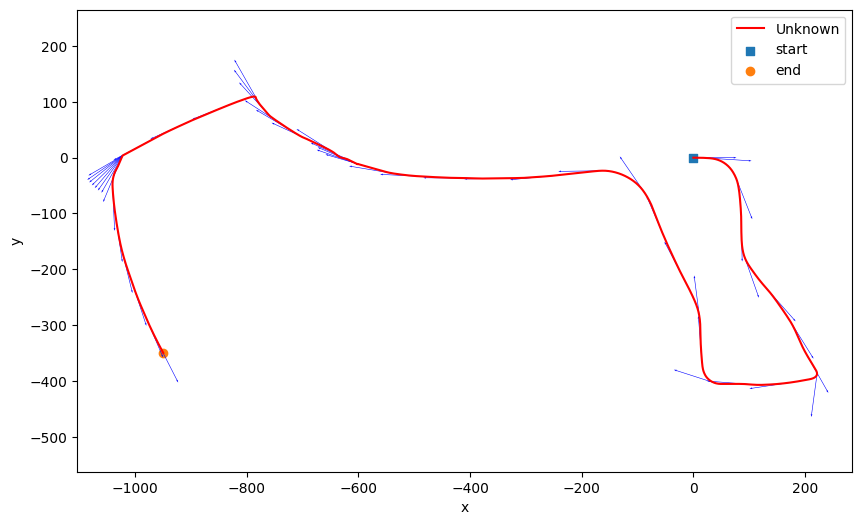

(<Figure size 1000x600 with 1 Axes>, <Axes: xlabel='x', ylabel='y'>)

In [6]:
twistvel = np.hstack((lin_vel, ang_vel))  # (N,6)
timediff = np.squeeze(stamps[1:] - stamps[0:-1], axis=1)   # (N-1,)

twistvelhat = axangle2twist(twistvel)   # (N,4,4)
twistvelcurlyhat = axangle2adtwist(twistvel)  # (N,6,6)

twistdisthat = twistvelhat[:-1] * timediff[:,None,None]           # (N-1,4,4)
twistdistcurlyhat = twistvelcurlyhat[:-1] * timediff[:,None,None]   # (N-1,6,6)

# initialize the state at t=0 as identity pose matrix in SE(3)
meanPose = np.zeros((N,4,4))
meanPose[0] = np.eye(4)
covPose = np.eye(6) * initPoseCov     # (6,6)

for t in tqdm(range(0, N-1)):
    expm_twistdisthat = scipy.linalg.expm(twistdisthat[t])               # (4,4)
    expm_twistdistcurlyhat = scipy.linalg.expm(-twistdistcurlyhat[t])    # (6,6)

    meanPose[t+1] = np.matmul(meanPose[t], expm_twistdisthat)
    covPose = np.matmul(np.matmul(expm_twistdistcurlyhat, covPose), expm_twistdistcurlyhat.T) + W

# You can use the function below to visualize the robot pose over time
# visualize_trajectory_2d(world_T_imu, show_ori=True)
visualize_trajectory_2d(np.transpose(meanPose, (1,2,0)), show_ori=True)

## (b) Landmark Mapping via EKF Update

100%|████████████████████████████████████| 3026/3026 [00:00<00:00, 19201.13it/s]


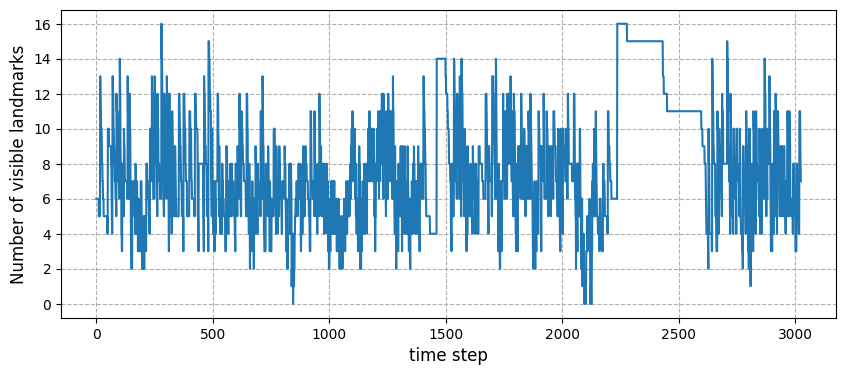

In [7]:
def plotLMTimeVar(features, N):
    """
        plot the number of landmarks visible wrt time
        input:
            features: (N,M,4)
    """
    missObs = np.array([-1,-1,-1,-1])
    numVisLM = np.zeros((N))

    for t in tqdm(range(0, N)):
        tmp1 = features[t] - missObs         # (M,4)
        tmp2 = np.sum(np.abs(tmp1), axis=1)   # (M,)
        numVisLM[t] = np.sum(tmp2 != 0)
    
    figure = plt.figure(figsize=(10,4))
    plt.plot(numVisLM)
    plt.xlabel("time step", fontsize=12)
    plt.ylabel("Number of visible landmarks", fontsize=12)
    plt.grid(linestyle='--')
    plt.show()

plotLMTimeVar(features, N)

100%|████████████████████████████████████| 3025/3025 [00:00<00:00, 14292.28it/s]


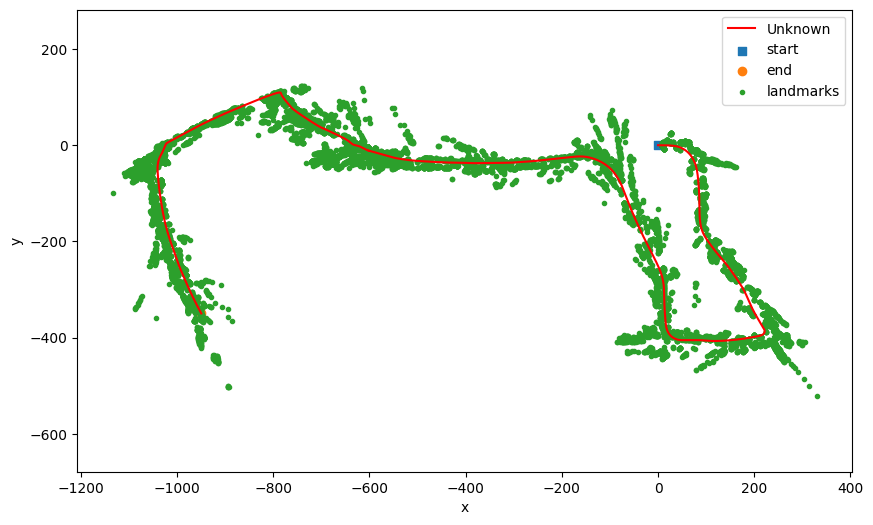

In [8]:
def getValidLandmarks(features, robotPose, distThresh=200):
    N,M,_ = features.shape
    missObs = np.array([-1,-1,-1,-1])

    # LMweights = np.zeros((N,M))
    nearLM2Robot = np.ones((M))
    deadReckLM = np.array([0,0,0])
    meanLMInit = np.zeros((M,3))

    for t in tqdm(range(0, N-1)):
        tmp1 = features[t] - missObs          # (M,4)
        tmp2 = np.sum(np.abs(tmp1), axis=1)   # (M,)
        invalidObsIdx = np.where(tmp2 == 0)[0]   
        validObsIdx = np.where(tmp2 > 0)[0]     # (Nt,)
        Nt = validObsIdx.shape[0]

        validFeat = features[t,validObsIdx,:]              # (Nt,4)
        z = -Ks[2,3] / (validFeat[:,0] - validFeat[:,2])   # (Nt,)
        x = (1/Ks[0,0]) * (validFeat[:,0] - Ks[0,2]) * z   # (Nt,)
        y = (1/Ks[1,1]) * (validFeat[:,1] - Ks[1,2]) * z   # (Nt,)

        OFcoord = np.stack((x,y,z), axis=1)   # (Nt,3)
        OFcoordHom = np.ones((Nt,4))
        OFcoordHom[:,:3] = OFcoord
#         OFcoordHom = np.matmul(RF_T_OF, OFcoordHom.T).T     # (Nt,4)
        IFcoordHom = np.matmul(IF_T_CF, OFcoordHom.T).T     # (Nt,4)
        WFcoordHom = np.matmul(meanPose[t], IFcoordHom.T).T  # (Nt,4)
        WFcoord = WFcoordHom[:,:3]    # (Nt,3)

        meanLMInit[validObsIdx] = WFcoord    # (M,3)
        distLMRobot = np.linalg.norm(WFcoord[:,:3] - robotPose[t,:3,3], axis=1)  # (Nt,)
        farLM2RobotIdx = validObsIdx[np.where(distLMRobot > distThresh)[0]]
        nearLM2Robot[farLM2RobotIdx] = 0

#         nearLM2RobotIdx = validObsIdx[np.where(distLMRobot <= distThresh)[0]]
#         LMweights[t,nearLM2RobotIdx] = 1
        deadReckLM = np.vstack((deadReckLM, WFcoord[np.where(distLMRobot <= distThresh)[0]]))

    deadReckLM = deadReckLM[1:]
    visualize_trajectory_2d(np.transpose(robotPose, (1,2,0)), landmarks=deadReckLM, 
                            path_name="Unknown", show_ori=False)
    nearLM2RobotIdx = np.where(nearLM2Robot > 0)[0]      # (<M,)

    return nearLM2RobotIdx, meanLMInit

nearLM2RobotIdx, meanLMInit = getValidLandmarks(features, meanPose, distThresh=200)

In [67]:
weights = np.sum(LMweights, axis=0)
plt.figure(figsize=(6,4))
plt.plot(weights)
plt.grid()
plt.show()

NameError: name 'LMweights' is not defined

In [23]:
a = np.random.randint(1,9,(5,3))
print(a)

b = np.matrix.flatten(a)
print(b)

c = np.reshape(b, (-1,3))
print(c)

[[6 2 3]
 [1 8 2]
 [5 5 2]
 [3 3 5]
 [2 1 6]]
[6 2 3 1 8 2 5 5 2 3 3 5 2 1 6]
[[6 2 3]
 [1 8 2]
 [5 5 2]
 [3 3 5]
 [2 1 6]]


In [20]:
cov = np.random.randint(1,9,(10,10))
print(cov)

rows = [0,1,2]
c = cov[rows,rows]
b = cov[rows][:,rows]
# c = b[:,rows]
# print(b)
print(b)
print(c)

[[7 7 6 1 8 4 6 8 4 7]
 [8 5 1 3 6 3 1 4 1 2]
 [6 6 8 6 2 5 6 4 5 7]
 [1 2 1 8 3 2 8 6 8 8]
 [7 6 7 7 3 7 6 1 4 6]
 [6 7 1 4 2 2 8 6 1 1]
 [2 1 3 4 1 7 3 5 8 6]
 [6 8 6 3 7 2 8 6 7 5]
 [3 7 7 7 7 1 6 8 7 5]
 [6 4 4 6 5 2 7 3 2 1]]
[[7 7 6]
 [8 5 1]
 [6 6 8]]
[7 5 8]


## Approach 2

In [18]:
# pick the top 500 landmarks
# topk = 1500
# topkIdx = np.argsort(weights)[::-1][0:topk]
# topkIdx = np.arange(0,M)
featuresk = features[:,nearLM2RobotIdx]   # (N,M,4)
M = featuresk.shape[1]

missObs = np.array([-1,-1,-1,-1])
meanPoseInv = inversePose(meanPose)   # (N,4,4)

# initialize the gaussian mean and covariance matrix for M landmarks
meanLM = np.matrix.flatten(meanLMInit[nearLM2RobotIdx])       # (3M,)
covLM = np.diag(np.full(shape=(3*M), fill_value=initLMCov))   # (3M,3M)
IkroV = getIkroV(V, M)

num_itr = 1
for itr in range(num_itr):
    for t in tqdm(range(0, N-1)):
        tmp1 = featuresk[t] - missObs        # (M,4)
        tmp2 = np.sum(np.abs(tmp1), axis=1)  # (M,)
        validObsBool = (tmp2 > 0)            # (M,)
        validObsIdx = np.where(tmp2 > 0)[0]  # (Nt,)

        validFeat = featuresk[t,validObsIdx,:]  # (Nt,4)
        Nt = validFeat.shape[0]

        meanLMHom = getHomoCoord(meanLM)            # (4M,)
        meanLMHom = np.reshape(meanLMHom, (-1,4))   # (M,4)

        IFcoord = np.matmul(meanPoseInv[t+1], meanLMHom[validObsIdx].T).T  # (Nt,4)
        OFcoord = np.matmul(CF_T_IF, IFcoord.T).T         # (Nt,4)
        predObs = np.matmul(Ks, projection(OFcoord).T).T   # (Nt,4)
        OFcoordJac = projectionJacobian(OFcoord)   # (Nt,4,4)

        tmp1 = np.matmul(Ks, np.matmul(OFcoordJac, CF_T_IF))         # (Nt,4,4)
        H = np.matmul(tmp1, np.matmul(meanPoseInv[t+1], P_const.T))   # (Nt,4,3)
        HLM = np.zeros((4*Nt,3*M))     # (4Nt,3M)
        for j in range(Nt):
            HLM[j*4:j*4+4, validObsIdx[j]*3:validObsIdx[j]*3+3] = H[j]

        B = np.matmul(HLM, covLM)     # (4Nt,3M)
        A = np.matmul(B, HLM.T) + IkroV[0:4*Nt,0:4*Nt]   # (4Nt,4Nt)
        KG = np.linalg.solve(A, B).T      # (3M,4Nt)
        
        row1 = validObsIdx*3     # (Nt,)
        rows = np.matrix.flatten(np.vstack((row1,row1+1,row1+2)).T)   # (3Nt)

        obsError = np.matrix.flatten(validFeat - predObs)     # (4Nt,)
        meanLM[rows] = meanLM[rows] + np.matmul(KG[rows], obsError)
        covLM[rows][:,rows] = covLM[rows][:,rows] - np.matmul(np.matmul(KG[rows], HLM[:,rows]), covLM[rows][:,rows])

meanLMmat = np.reshape(meanLM, (-1,3))

 16%|██████▌                                 | 499/3025 [00:09<01:08, 36.64it/s]/Users/barkat/Desktop/UCSD/academic/Winter23/ECE276A/assignments/project3/code/pr3_utils.py:97: RuntimeWarning: invalid value encountered in divide
  return ph/ph[...,2,None]
/Users/barkat/Desktop/UCSD/academic/Winter23/ECE276A/assignments/project3/code/pr3_utils.py:106: RuntimeWarning: divide by zero encountered in divide
  iph2 = 1.0/ph[...,2]
/Users/barkat/Desktop/UCSD/academic/Winter23/ECE276A/assignments/project3/code/pr3_utils.py:109: RuntimeWarning: invalid value encountered in divide
  J[...,0,2] = -ph[...,0]/ph2ph2
/Users/barkat/Desktop/UCSD/academic/Winter23/ECE276A/assignments/project3/code/pr3_utils.py:110: RuntimeWarning: invalid value encountered in divide
  J[...,1,2] = -ph[...,1]/ph2ph2
/Users/barkat/Desktop/UCSD/academic/Winter23/ECE276A/assignments/project3/code/pr3_utils.py:111: RuntimeWarning: invalid value encountered in divide
  J[...,3,2] = -ph[...,3]/ph2ph2
/var/folders/2g/3m1__srs6s

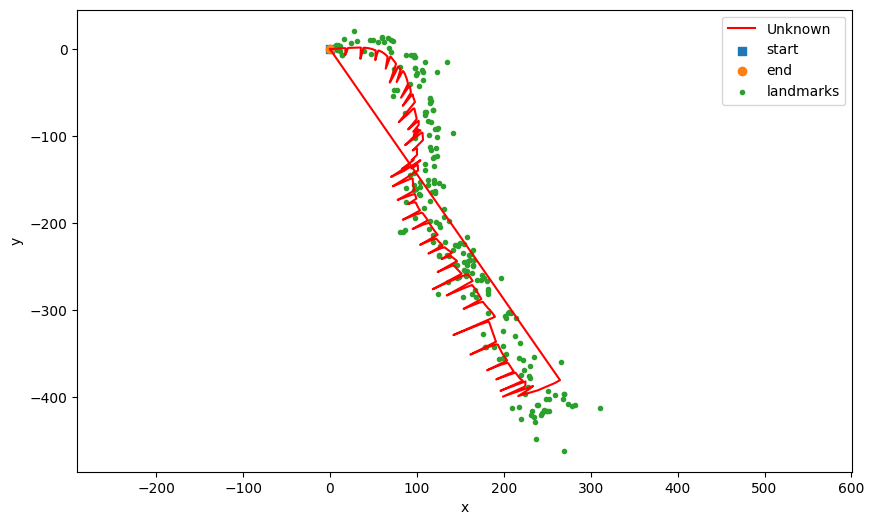

(<Figure size 1000x600 with 1 Axes>, <Axes: xlabel='x', ylabel='y'>)

In [19]:
# meanLMmat = np.clip(meanLMmat, -1500, 500)
visualize_trajectory_2d(np.transpose(meanPose, (1,2,0)), landmarks=meanLMmat, 
                        path_name="Unknown", show_ori=False)

In [23]:
a = np.random.randint(1,9,(2,4,6))
print(a)

b = np.reshape(a, (-1,6))
print(b)

[[[7 7 1 6 5 5]
  [6 8 4 8 4 5]
  [1 3 3 2 3 3]
  [3 3 8 2 5 7]]

 [[8 6 4 1 7 1]
  [4 7 2 5 8 3]
  [2 7 6 4 8 2]
  [4 3 6 6 3 8]]]
[[7 7 1 6 5 5]
 [6 8 4 8 4 5]
 [1 3 3 2 3 3]
 [3 3 8 2 5 7]
 [8 6 4 1 7 1]
 [4 7 2 5 8 3]
 [2 7 6 4 8 2]
 [4 3 6 6 3 8]]


## Visual-Inertial SLAM

In [20]:
opt = "part"
twistvel = np.hstack((lin_vel, ang_vel))     # (N,6)
timediff = np.squeeze(stamps[1:] - stamps[0:-1], axis=1)   # (N-1,)

twistvelhat = axangle2twist(twistvel)   # (N,4,4)
twistvelcurlyhat = axangle2adtwist(twistvel)  # (N,6,6)

twistdisthat = twistvelhat[:-1] * timediff[:,None,None]           # (N-1,4,4)
twistdistcurlyhat = twistvelcurlyhat[:-1] * timediff[:,None,None]   # (N-1,6,6)

# pick the top 500 landmarks
# topk = 1500
# topkIdx = np.argsort(weights)[::-1][0:topk]
# topkIdx = np.arange(0,M)
featuresk = features[:,nearLM2RobotIdx]   # (N,M,4)
M = featuresk.shape[1]
missObs = np.array([-1,-1,-1,-1])

# initialize the gaussian mean and covariance matrix for M landmarks
meanLM = np.matrix.flatten(meanLMInit[nearLM2RobotIdx])       # (3M,)
meanLMmat = np.reshape(meanLM, (-1,3))
covLM = np.diag(np.full(shape=(3*M), fill_value=initLMCov))   # (3M,3M)
IkroV = getIkroV(V, M)

# initialize the state at t=0 as identity pose matrix in SE(3)
meanPose = np.zeros((N,4,4))   # (N,4,4)
meanPose[0] = np.eye(4)
covPose = np.eye(6) * initPoseCov     # (6,6)

covSLAM = np.zeros((3*M+6,3*M+6))   # (3M+6,3M+6)
covSLAM[0:3*M,0:3*M] = covLM
covSLAM[3*M:3*M+6,3*M:3*M+6] = covPose

covdiagsum = []
robotRowIdx = [3*M,3*M+1,3*M+2,3*M+3,3*M+4,3*M+5]
num_itr = 1
for itr in range(num_itr):
    for t in tqdm(range(0, 500)):
        # Prediction step for the SE(3) pose
        expm_twistdisthat = scipy.linalg.expm(twistdisthat[t])               # (4,4)
        expm_twistdistcurlyhat = scipy.linalg.expm(-twistdistcurlyhat[t])    # (6,6)

        meanPose[t+1] = np.matmul(meanPose[t], expm_twistdisthat)
        meanPoseInv = inversePose(meanPose[None,t+1])[0]     # (4,4)

        F = expm_twistdistcurlyhat
        covSLAM[3*M:3*M+6,3*M:3*M+6] = np.matmul(np.matmul(F, covSLAM[3*M:3*M+6,3*M:3*M+6]), F.T) + W
        covSLAM[0:3*M,3*M:3*M+6] = np.matmul(covSLAM[0:3*M,3*M:3*M+6], F.T)
        covSLAM[3*M:3*M+6,0:3*M] = np.matmul(F, covSLAM[3*M:3*M+6,0:3*M])
        
        # Visual Map Update
        tmp1 = featuresk[t+1] - missObs        # (M,4)
        tmp2 = np.sum(np.abs(tmp1), axis=1)  # (M,)
        validObsIdx = np.where(tmp2 > 0)[0]  # (Nt,)
        validFeat = featuresk[t,validObsIdx,:]  # (Nt,4)
        Nt = validFeat.shape[0]

        meanLMHom = getHomoCoord(meanLM)            # (4M,)
        meanLMHom = np.reshape(meanLMHom, (-1,4))   # (M,4)

        IFcoord = np.matmul(meanPoseInv, meanLMHom[validObsIdx].T).T  # (Nt,4)
        OFcoord = np.matmul(CF_T_IF, IFcoord.T).T         # (Nt,4)
        predObs = np.matmul(Ks, projection(OFcoord).T).T   # (Nt,4)
        OFcoordJac = projectionJacobian(OFcoord)   # (Nt,4,4)

        tmp1 = np.matmul(Ks, np.matmul(OFcoordJac, CF_T_IF))    # (Nt,4,4)
        tmp2 = computeCircDot(IFcoord)   # (Nt,4,6)
        H = -np.matmul(tmp1, tmp2)       # (Nt,4,6)
        Hrobot = np.reshape(H, (-1,6))   # (4Nt,6)

        H = np.matmul(tmp1, np.matmul(meanPoseInv, P_const.T))  # (Nt,4,3)
        
        row1 = validObsIdx*3     # (Nt,)
        rowsLM = np.matrix.flatten(np.vstack((row1,row1+1,row1+2)).T)     # (3Nt,)
        rowsLMRobot = np.append(rowsLM, robotRowIdx)                      # (3Nt+6,)

        if opt == "full":
            # for full KG computation
            HLM = np.zeros((4*Nt,3*M))     # (4Nt,3M)
            for j in range(Nt):
                HLM[j*4:j*4+4, validObsIdx[j]*3:validObsIdx[j]*3+3] = H[j]
            HSLAM = np.hstack((HLM, Hrobot))    # (4Nt,3M+6)

            B = np.matmul(HSLAM, covSLAM)       # (4Nt,3M+6)
            A = np.matmul(B, HSLAM.T) + IkroV[0:4*Nt,0:4*Nt]   # (4Nt,4Nt)
            KG = np.linalg.solve(A,B).T         # (3M+6,4Nt)
            KGLM = KG[0:3*M]         # (3M,4Nt)
            KGrobot = KG[3*M:3*M+6]  # (6,4Nt)

            # update the map landmarks mean and covariance
            obsError = np.matrix.flatten(validFeat - predObs)               # (4Nt,)
            obsError = np.clip(obsError, -50, 50)
            meanLM[rowsLM] = meanLM[rowsLM] + np.matmul(KGLM[rowsLM], obsError)

            # update the robot pose mean and covariance
            scaledError = np.matmul(KGrobot, obsError)   # (6,)
            meanPoseUpdate = axangle2pose(scaledError[None,:])[0]   # (4,4)
            meanPose[t+1] = np.matmul(meanPose[t+1], meanPoseUpdate)
            covSLAM[rowsLMRobot][:,rowsLMRobot] = np.matmul(np.eye(3*Nt+6) - np.matmul(KG[rowsLMRobot], HSLAM[:,rowsLMRobot]), 
                                                covSLAM[rowsLMRobot][:,rowsLMRobot])
        elif opt == "part":
            # for partial small KG computation
            HLM = np.zeros((4*Nt,3*Nt))     # (4Nt,3Nt)
            for j in range(Nt):
                HLM[j*4:j*4+4, j*3:j*3+3] = H[j]
            HSLAM = np.hstack((HLM, Hrobot))    # (4Nt,3Nt+6)

            validcovSLAM = covSLAM[rowsLMRobot][:,rowsLMRobot]    # (3Nt+6,3Nt+6)
            B = np.matmul(HSLAM, validcovSLAM)       # (4Nt,3Nt+6)
            A = np.matmul(B, HSLAM.T) + IkroV[0:4*Nt,0:4*Nt]   # (4Nt,4Nt)
            KG = np.linalg.solve(A,B).T              # (3Nt+6,4Nt)
            KGLM = KG[0:3*Nt]          # (3Nt,4Nt)
            KGrobot = KG[3*Nt:3*Nt+6]  # (6,4Nt)

            obsError = np.matrix.flatten(validFeat - predObs)           # (4Nt,)
#             obsError = np.clip(obsError, -50, 50)
            meanLM[rowsLM] = meanLM[rowsLM] + np.matmul(KGLM, obsError)

            # update the robot pose mean and covariance
            scaledError = np.matmul(KGrobot, obsError)   # (6,)
            meanPoseUpdate = axangle2pose(scaledError[None,:])[0]   # (4,4)
            meanPose[t+1] = np.matmul(meanPose[t+1], meanPoseUpdate)
            covSLAM[rowsLMRobot][:,rowsLMRobot] = np.matmul(np.eye(3*Nt+6) - np.matmul(KG, HSLAM), 
                                                            covSLAM[rowsLMRobot][:,rowsLMRobot])

        covdiagsum.append(np.sum(np.diag(covSLAM)))

100%|█████████████████████████████████████████| 500/500 [08:04<00:00,  1.03it/s]


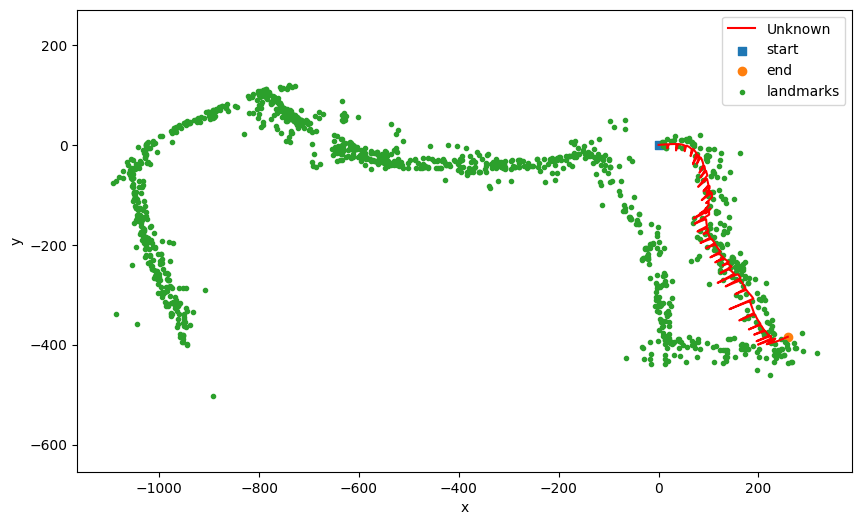

(<Figure size 1000x600 with 1 Axes>, <Axes: xlabel='x', ylabel='y'>)

In [16]:
meanLMmat = np.reshape(meanLM, (-1,3))
visualize_trajectory_2d(np.transpose(meanPose[0:500], (1,2,0)), landmarks=meanLMmat, show_ori=False)

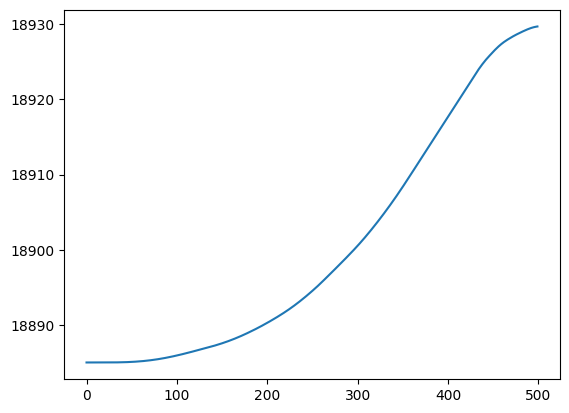

In [12]:
fig = plt.figure()
plt.plot(covdiagsum)

In [43]:
validObsIdx = np.array([0,3,6])
row1 = validObsIdx*3     # (Nt,)
rowsLM = np.matrix.flatten(np.vstack((row1,row1+1,row1+2)).T)     # (3Nt,)
rowsLMRobot = np.append(rowsLM, robotRowIdx)                      # (3Nt+6,)
print(row1)
print(rowsLM)
print(rowsLMRobot)

[ 0  9 18]
[ 0  1  2  9 10 11 18 19 20]
[   0    1    2    9   10   11   18   19   20 3777 3778 3779 3780 3781
 3782]


In [45]:
3*M

3777